# **Entrenamiento y evaluación de un sistema de edición de luz basado en perceptrón multicapa**

_________________________________________________________________________________________________________________________________________________________________________________________________________
Angel Toledo Flores<br>
Ingeniero Mecánico Agrícola/Ingeniero en Sistemas Computacionales.<br>
**E-mail**: contactoangeltoledo@gmail.com<br>
 [Linkedin profile](https://www.linkedin.com/in/angel-toledo/) | [Portafolio de proyectos](https://resume.ingesaurio.com) <br> 
 [ DataSet: kagle](https://www.kaggle.com/code/shruthimshruthim/google-scrapped-image)


In [1]:
import cv2 
import matplotlib.pyplot as plt
import random
import numpy as np


# ImportData

## Google

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!mkdir /content/image_input

In [4]:
!cp -R /content/gdrive/MyDrive/Automatic_light_editing/image_input/* /content/image_input

# Setings

In [5]:
import glob
import cv2 
import matplotlib.pyplot as plt
import random
import numpy as np

def splitDataset(PATH = '/content/image_input/*', test = 0.3):
  train_d = []
  test_d = glob.glob(PATH)
  for i in range(int(len(test_d)*test)):
    random_img = random.choice(test_d)
    train_d.append(random_img)
    test_d.remove(random_img)
  return train_d, test_d

def read_img(PATH):
  """
  Read img and transform to HSV
  """
  img = cv2.imread(PATH)
  img = cv2.resize(img,(128,128))
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) / 255.0
  return hsv

def gen_data(hsv):
  """ 
  Edit ligth in the value V in RSV
  """
  d_sigma = (0.1 * random.choice([i for i in range(3,17) if i not in [9,10,11]]) )
  v =  hsv[:,:,2] * d_sigma
  v = np.array(v)
  return [v,d_sigma]

def create_dataSet(path_list, n=7):
  """
  Create 3 new img whit diferent light values for img
  """
  x_t = []
  y_t = []
  HSV_ARRAY = []
  for element in path_list:
    hsv = read_img(element)
    for i in range(n):
        x,y = gen_data(hsv)
        x_t.append(x)
        y_t.append(y) 
        HSV_ARRAY.append(hsv)
  return x_t, y_t, HSV_ARRAY

# Train

In [6]:
import glob
import numpy as np
#path_list = glob.glob('/content/image_input/*')
train_list, test_list = splitDataset()
x_train, y_train, HSV_TRAIN = create_dataSet(train_list)
x_test, y_test, HSV_TEST = create_dataSet(test_list)


x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train.shape

(2744, 128, 128)


(2744, 128, 128)

In [7]:
x_train.shape

(2744, 128, 128)

In [9]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
import numpy
import tensorflow as tf
from keras.models import Model

seed = 7
numpy.random.seed(seed)
model = Sequential()
input = layers.Input(shape=(128,128,1))
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPool2D((2, 2), padding="same")(x)
x = layers.Flatten()(x)
x = Dense(12, activation='relu') (x)
x = Dense(8, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

losse = tf.keras.losses.MeanAbsoluteError()

model.compile(loss=losse, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, batch_size=10)




Epoch 1/50
275/275 [==============================] - 24s 87ms/step - loss: 0.2789 - accuracy: 0.0000e+00
Epoch 2/50
275/275 [==============================] - 23s 85ms/step - loss: 0.0949 - accuracy: 0.0000e+00
Epoch 3/50
275/275 [==============================] - 23s 85ms/step - loss: 0.0728 - accuracy: 0.0000e+00
Epoch 4/50
275/275 [==============================] - 23s 84ms/step - loss: 0.0634 - accuracy: 0.0000e+00
Epoch 5/50
275/275 [==============================] - 23s 84ms/step - loss: 0.0575 - accuracy: 0.0000e+00
Epoch 6/50
275/275 [==============================] - 23s 84ms/step - loss: 0.0607 - accuracy: 0.0000e+00
Epoch 7/50
275/275 [==============================] - 23s 84ms/step - loss: 0.0510 - accuracy: 0.0000e+00
Epoch 8/50
275/275 [==============================] - 23s 84ms/step - loss: 0.0502 - accuracy: 0.0000e+00
Epoch 9/50
275/275 [==============================] - 23s 84ms/step - loss: 0.0544 - accuracy: 0.0000e+00
Epoch 10/50
275/275 [=========================

In [10]:
predict_gama = model.predict(x_test)
model.save('convPerceptronModel.h5')

# Eval

In [11]:
from keras.metrics import Precision
from matplotlib.colors import hsv_to_rgb
# Eval
ERROR = []
for i in range(len(predict_gama)):
  # original 
  hsv_origi = np.copy(HSV_TEST[i])
  RGB_ORIGI = hsv_to_rgb(hsv_origi)

  #Edit
  hsv_edit = np.copy(HSV_TEST[i])
  v = x_test[i]
  v = v.reshape((128,128))
  hsv_edit[:,:,2] = v
  RGB_EDIT = hsv_to_rgb(hsv_edit)

  # inferencia 
  hsv_pred = np.copy(HSV_TEST[i])
  VV = x_test[i]
  VV = VV.reshape((128,128))
  hsv_pred[:,:,2] = VV / predict_gama[i]
  RGB_PREDICT = hsv_to_rgb(hsv_pred)

  # Diferencia
  RGB_DIFF = RGB_ORIGI - RGB_PREDICT

  mean_diference = abs(np.mean(RGB_DIFF))
  mean_original = abs(np.mean(RGB_ORIGI))
  error_img = mean_diference / mean_original 
  ERROR.append(error_img)
  #print(error_img)
print('___________________________________')
print('___________________________________')
precision_model = 1 - abs(np.mean(ERROR))
print('model presicion: ', round(precision_model,3) )

___________________________________
___________________________________
model presicion:  0.787


___________________________________________________________________________________


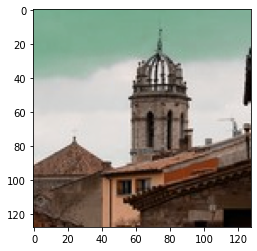

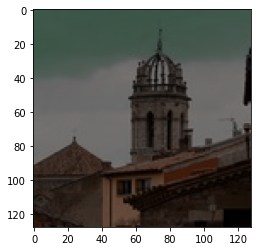

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


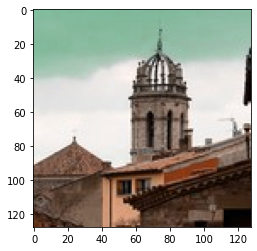

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


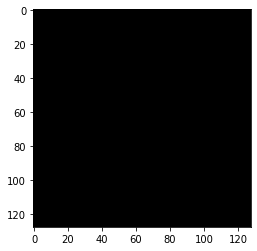

___________________________________________________________________________________


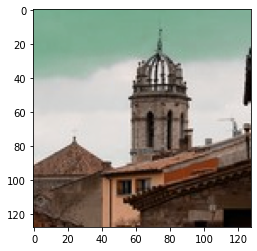

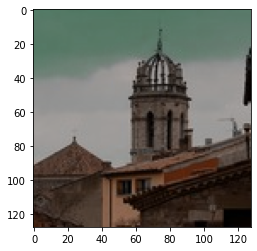

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


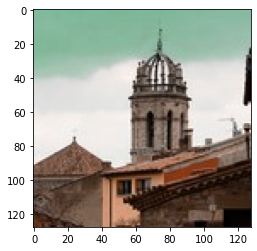

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


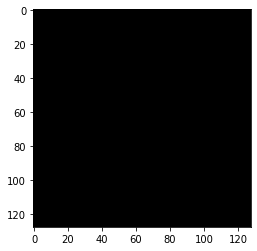

___________________________________________________________________________________


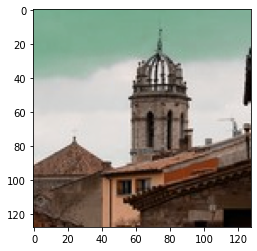

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


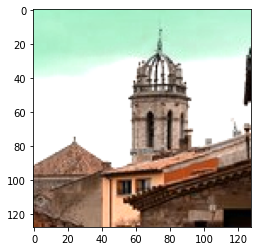

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


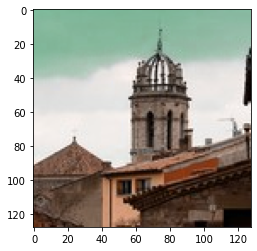

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


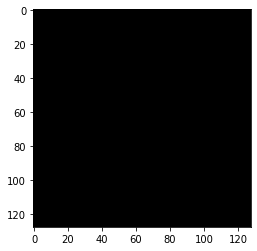

___________________________________________________________________________________


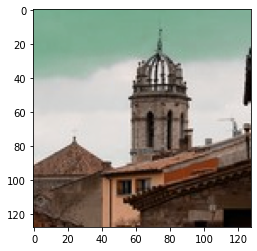

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


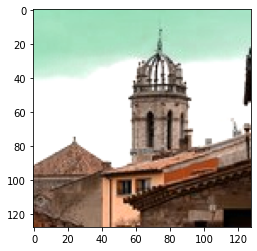

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


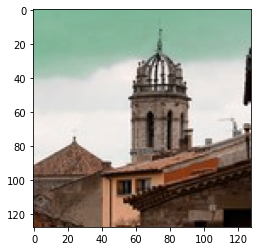

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


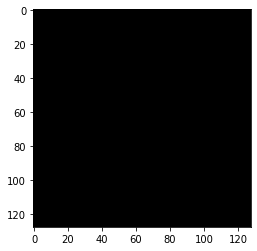

___________________________________________________________________________________


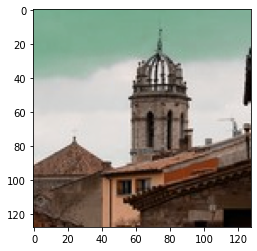

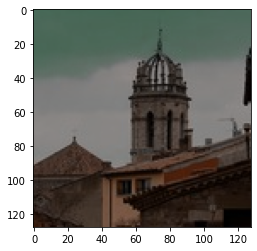

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


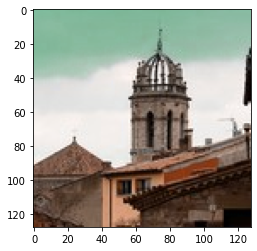

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


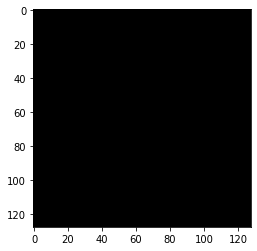

___________________________________________________________________________________


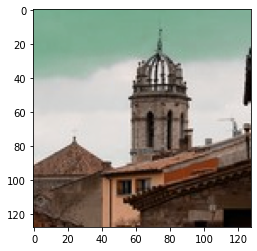

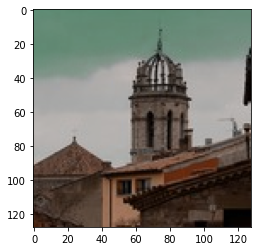

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


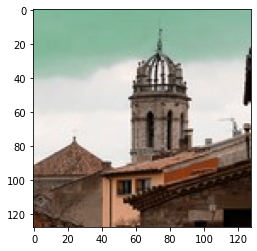

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


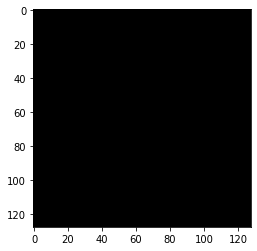

___________________________________________________________________________________


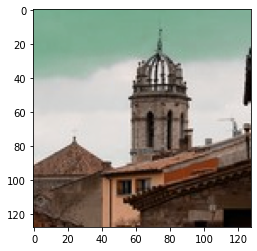

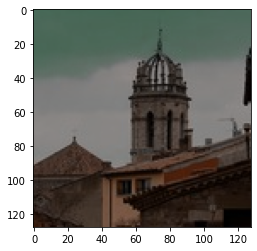

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


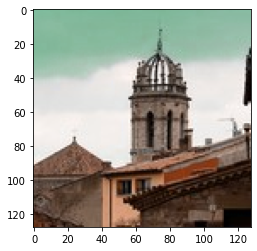

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


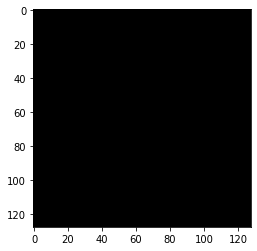

___________________________________________________________________________________


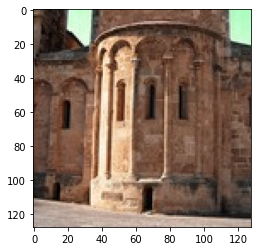

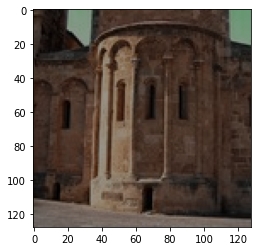

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


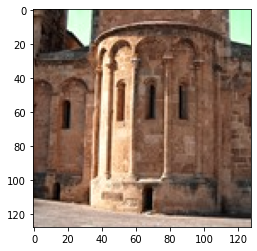

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


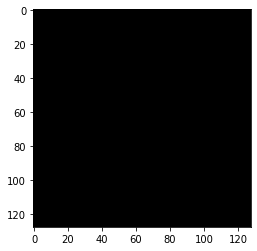

___________________________________________________________________________________


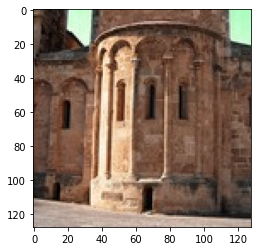

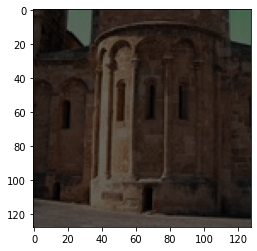

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


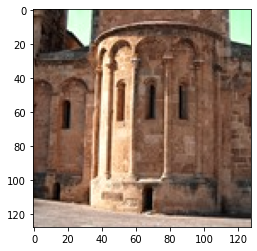

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


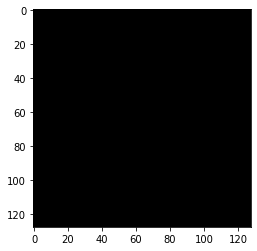

___________________________________________________________________________________


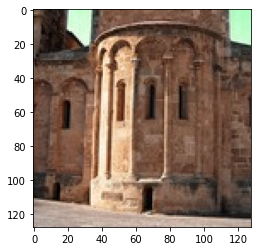

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


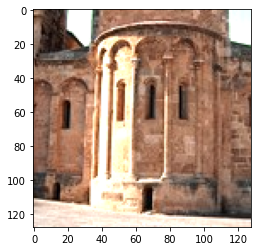

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


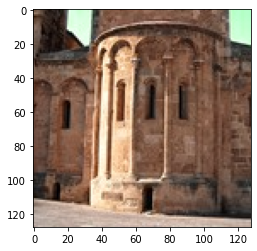

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


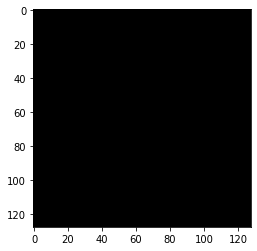

In [12]:
from keras.metrics import Precision
# Show examples
for i in range(10):
  print('___________________________________________________________________________________')
  # original 
  hsv_origi = np.copy(HSV_TEST[i])
  RGB_ORIGI = hsv_to_rgb(hsv_origi)
  plt.imshow(RGB_ORIGI)
  plt.show()

  #Edit
  hsv_edit = np.copy(HSV_TEST[i])
  v = x_test[i]
  v = v.reshape((128,128))
  hsv_edit[:,:,2] = v
  RGB_EDIT = hsv_to_rgb(hsv_edit)
  plt.imshow(RGB_EDIT)
  plt.show()

  # inferencia 
  hsv_pred = np.copy(HSV_TEST[i])
  VV = x_test[i]
  VV = VV.reshape((128,128))
  hsv_pred[:,:,2] = VV / predict_gama[i]
  RGB_PREDICT = hsv_to_rgb(hsv_pred)
  plt.imshow(RGB_PREDICT)
  plt.show()

  # Diferencia
  RGB_DIFF = RGB_ORIGI - RGB_PREDICT
  plt.imshow(RGB_DIFF)
  plt.show()